# README

Il y a 3 notebooks : 
- PSanté_01_notebooknettoyage : ce qui touche au preprocessing 
- PSanté_02_notebooknettoyage : ce qui touche à la modélisation 
- Analyse_anomalie : qui est un copié-collé de PSanté_02_notebooknettoyage, avec à la fin toutes les tests que j'ai réalisé pour essayer de comprendre le pb. J'ai éclaté certaines de mes fonctions pour qu'on puisse plus facilement accéder aux variables. 

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from numpy import percentile
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import shapiro
import pickle 
from sklearn.neighbors import KDTree
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro
from scipy.stats import f_oneway
import sklearn.metrics as metrics
import math
import time
start_time = time.time()

In [2]:
outliers=pd.read_csv("Data/export_outliers.csv",low_memory=False)
train=pd.read_csv("Data/train_export.csv")
test=(
    pd.read_csv("Data/test_export.csv")
    .drop(columns=['Numb_nan_line'],axis=1))

In [3]:
test.shape

(101579, 15)

# Verification imputer 

In [4]:
#We want to check the efficiency of our imputer, so we are going to transform some none Nan values by some Nan
#And then compare 
test.loc[test['code']=='7616700102017','proteins_100g']=test.loc[test['code']=='7616700102017',
                                                                 'proteins_100g']=np.nan
test.loc[test['code']=='3267110007023','fiber_100g']=test.loc[test['code']=='3267110007023','fiber_100g']=np.nan
test.loc[test['code']=='3266920007515','energy_100g']=test.loc[test['code']=='3266920007515','energy_100g']=np.nan
test.loc[test['code']=='0400101046431','sugars_100g']=test.loc[test['code']=='0400101046431',
                                                                 'sugars_100g']=np.nan

In [5]:
test.head(n=20)

,code,product_name,generic_name,quantity,fiber_100g,proteins_100g,fruits-vegetables-nuts_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,nutrition-score-fr_100g,carbohydrates_100g,fat_100g,nutriscore_grade
0,4250665323358,Magnesium-Citrat,NaN,℮ 250 g,0.0,0.00,NaN,1139.0,0.00,1.50,0.03000,3.0,4.20,0.00,c
1,3268350120688,Biscottes à la farine complète et graines de lin,Biscottes à la farine complète et graines de lin,270 g,12.4,13.40,NaN,1622.0,1.20,0.30,1.40000,6.0,72.00,7.90,c
2,4335896750255,Bio Tofu Hack,NaN,200 g,0.5,21.00,NaN,1120.0,2.90,0.80,0.93000,4.0,5.20,18.00,c
3,8801005123495,Crispy seaweed snack,NaN,NaN,NaN,50.00,NaN,1799.0,0.00,3.00,2.00000,13.0,50.00,0.00,d
4,0213400023290,Filet de poulet,NaN,NaN,NaN,23.00,NaN,435.0,0.40,0.00,0.11000,-4.0,0.00,1.30,a
5,0725439980890,Hummus,NaN,NaN,3.6,7.14,NaN,598.0,0.00,3.57,0.90678,-2.0,17.86,5.36,a
6,8437000639404,Claras de huevo,NaN,NaN,NaN,11.30,NaN,209.0,0.00,0.70,0.30000,-4.0,0.70,0.00,a
7,5708190025050,Rooibos Tea Elderberry Ginger Ginseng Agave,NaN,330 ml e,0.0,0.00,NaN,71.0,0.00,3.80,0.00300,6.0,3.90,0.00,d
8,3564707121231,Compotes multi variétés allégées en sucres bio,NaN,12 x 90 g,1.6,0.50,96.0,273.0,0.10,13.80,0.01000,-3.0,15.50,0.50,a
9,3760074411306,Galettes bretonnes,NaN,NaN,NaN,8.20,NaN,2167.0,19.00,18.00,0.74000,22.0,51.00,31.00,e


In [6]:
#This dataset was cleaned by a preprocessing done in the other notebook
train.shape

(189557, 14)

In [7]:
train.head()

,fiber_100g,proteins_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,carbohydrates_100g,fat_100g,mean_tree,code,product_name,nutrition-score-fr_100g,nutriscore_grade,verif
0,4.00,7.0,2293.0,19.5,15.5,0.16000,53.0,34.00,0.209743,5413415206304,Chocolat Lait Cannelle de Ceylan,22.0,e,94.00
1,2.90,3.9,674.0,0.7,0.9,1.50000,22.8,5.60,0.128701,3760054096042,Taboule Oriental,6.0,c,32.30
2,1.25,1.4,1197.0,0.3,18.5,0.00000,66.3,1.40,0.024792,3701269300432,Pâte à tartiner châtaigne cacao,12.0,d,69.10
3,0.00,20.0,1159.0,15.5,0.0,1.50000,0.0,21.90,0.054727,3177870001042,Camembert de Normandie,14.0,d,41.90
4,0.00,3.4,359.0,0.8,14.2,0.12319,15.4,1.42,0.052760,0056920052421,Yoplait Crémeux vanille,2.0,b,20.22


In [8]:
test.head()

,code,product_name,generic_name,quantity,fiber_100g,proteins_100g,fruits-vegetables-nuts_100g,energy_100g,saturated-fat_100g,sugars_100g,salt_100g,nutrition-score-fr_100g,carbohydrates_100g,fat_100g,nutriscore_grade
0,4250665323358,Magnesium-Citrat,NaN,℮ 250 g,0.0,0.0,NaN,1139.0,0.0,1.5,0.03,3.0,4.2,0.0,c
1,3268350120688,Biscottes à la farine complète et graines de lin,Biscottes à la farine complète et graines de lin,270 g,12.4,13.4,NaN,1622.0,1.2,0.3,1.40,6.0,72.0,7.9,c
2,4335896750255,Bio Tofu Hack,NaN,200 g,0.5,21.0,NaN,1120.0,2.9,0.8,0.93,4.0,5.2,18.0,c
3,8801005123495,Crispy seaweed snack,NaN,NaN,NaN,50.0,NaN,1799.0,0.0,3.0,2.00,13.0,50.0,0.0,d
4,0213400023290,Filet de poulet,NaN,NaN,NaN,23.0,NaN,435.0,0.4,0.0,0.11,-4.0,0.0,1.3,a


## I- Tests statistiques 

### 1) test de correlation 

Tests de normalité

Nous allons tester la normalité de la distribution statistique. Voici le test statistique :

H0 : les valeurs de la variable 'nutrition-score-fr_100g' pour l'échantillon sont issus d'une population normalement distribuée.

H1 : les valeurs de la variable 'nutrition-score-fr_100g' pour l'échantillon NE sont PAS issus d'une population normalement distribuée

In [9]:
# Shapiro-Wilk Test

# normality test
stat, p = shapiro(train['nutrition-score-fr_100g'])
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.974, p=0.000
Sample does not look Gaussian (reject H0)


/data/arnaud/.local/lib/python3.5/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [10]:
# normality test
liste=['fiber_100g', 'proteins_100g', 'energy_100g', 'saturated-fat_100g',
       'sugars_100g', 'salt_100g', 'carbohydrates_100g', 'fat_100g',
       'mean_tree', 'nutrition-score-fr_100g','verif']
for i in liste : 
    stat, p = shapiro(train[i])
    print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
    alpha = 0.05
    if p > alpha:
        print('For',i,'Sample looks Gaussian (fail to reject H0)')
    else:
        print('For',i,'Sample does not look Gaussian (reject H0)')

Statistics=0.833, p=0.000
For fiber_100g Sample does not look Gaussian (reject H0)
Statistics=0.884, p=0.000
For proteins_100g Sample does not look Gaussian (reject H0)
Statistics=0.956, p=0.000
For energy_100g Sample does not look Gaussian (reject H0)
Statistics=0.793, p=0.000
For saturated-fat_100g Sample does not look Gaussian (reject H0)
Statistics=0.788, p=0.000
For sugars_100g Sample does not look Gaussian (reject H0)
Statistics=0.868, p=0.000
For salt_100g Sample does not look Gaussian (reject H0)
Statistics=0.865, p=0.000
For carbohydrates_100g Sample does not look Gaussian (reject H0)
Statistics=0.857, p=0.000
For fat_100g Sample does not look Gaussian (reject H0)
Statistics=0.874, p=0.000
For mean_tree Sample does not look Gaussian (reject H0)
Statistics=0.974, p=0.000
For nutrition-score-fr_100g Sample does not look Gaussian (reject H0)
Statistics=0.917, p=0.000
For verif Sample does not look Gaussian (reject H0)


In [11]:
train.isna().sum()

fiber_100g                    0
proteins_100g                 0
energy_100g                   0
saturated-fat_100g            0
sugars_100g                   0
salt_100g                     0
carbohydrates_100g            0
fat_100g                      0
mean_tree                     0
code                          0
product_name               1159
nutrition-score-fr_100g       0
nutriscore_grade              1
verif                         0
dtype: int64

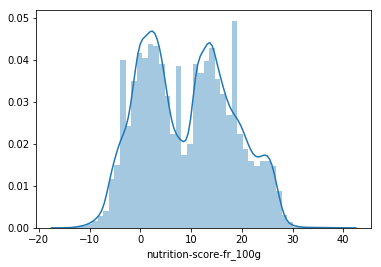

In [12]:
sns.distplot(train['nutrition-score-fr_100g']);

In [13]:
# Kolmogorov-Smirnov test
for i in liste : 
    stat, p = stats.kstest((train[i]),'norm')
    print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
    alpha = 0.05
    if p > alpha:
        print('For',i,'Sample looks Gaussian (fail to reject H0)')
    else:
        print('For',i,'Sample does not look Gaussian (reject H0)')


Statistics=0.500, p=0.000
For fiber_100g Sample does not look Gaussian (reject H0)
Statistics=0.727, p=0.000
For proteins_100g Sample does not look Gaussian (reject H0)
Statistics=0.999, p=0.000
For energy_100g Sample does not look Gaussian (reject H0)
Statistics=0.500, p=0.000
For saturated-fat_100g Sample does not look Gaussian (reject H0)
Statistics=0.605, p=0.000
For sugars_100g Sample does not look Gaussian (reject H0)
Statistics=0.500, p=0.000
For salt_100g Sample does not look Gaussian (reject H0)
Statistics=0.816, p=0.000
For carbohydrates_100g Sample does not look Gaussian (reject H0)
Statistics=0.686, p=0.000
For fat_100g Sample does not look Gaussian (reject H0)
Statistics=0.500, p=0.000
For mean_tree Sample does not look Gaussian (reject H0)
Statistics=0.737, p=0.000
For nutrition-score-fr_100g Sample does not look Gaussian (reject H0)
Statistics=0.986, p=0.000
For verif Sample does not look Gaussian (reject H0)


Une distribution bimodale est une distribution statistique présentant plusieurs modes et par définition ne suit pas une loi normale. 

In [14]:
heat1=train.copy()

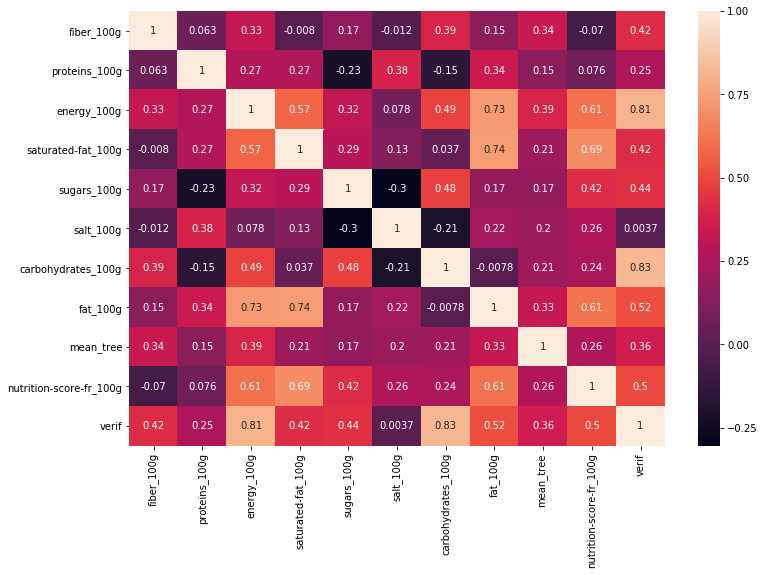

In [15]:
plt.figure(figsize=(12, 8))

vg_corr = heat1.corr()
sns.heatmap(vg_corr, 
            xticklabels = vg_corr.columns.values,
            yticklabels = vg_corr.columns.values,
            annot = True);

In [16]:
#Pearson correlation test 
from scipy.stats import pearsonr

stat, p = pearsonr(train['fat_100g'], train['saturated-fat_100g'])
print('stat=%.3f, p=%.3f' % (stat, p))

alpha=0.05

if p > alpha:
	print('fat_100g and saturated-fat_100g are probably independent')
else:
	print('fat_100g and saturated-fat_100g are probably dependent')


stat=0.736, p=0.000
fat_100g and saturated-fat_100g are probably dependent


## Anova 

In [17]:
train.columns

Index(['fiber_100g', 'proteins_100g', 'energy_100g', 'saturated-fat_100g',
       'sugars_100g', 'salt_100g', 'carbohydrates_100g', 'fat_100g',
       'mean_tree', 'code', 'product_name', 'nutrition-score-fr_100g',
       'nutriscore_grade', 'verif'],
      dtype='object')

In [18]:
X = "nutriscore_grade" # qualitative
Y = "fiber_100g" # quantitative

sous_echantillon = train.copy()
sous_echantillon.dropna(subset = ["product_name","nutriscore_grade"], inplace=True)


# Changement de la palette graphique
sns.set_palette(sns.color_palette("colorblind", 3))

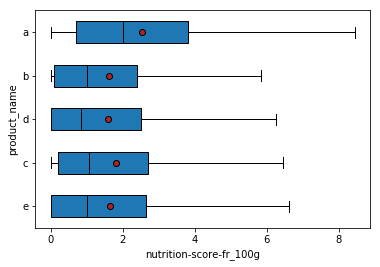

In [19]:
modalites = sous_echantillon[X].unique()
groupes = []
for m in modalites:
    groupes.append(sous_echantillon[sous_echantillon[X]==m][Y])
    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}
    
plt.boxplot(groupes, labels=modalites, showfliers=False, medianprops=medianprops, 
            vert=False, patch_artist=True, showmeans=True, meanprops=meanprops)
plt.xlabel("nutrition-score-fr_100g")
plt.ylabel("product_name")
plt.show()

In [20]:
# Example of the Analysis of Variance Test
stat, p = f_oneway(sous_echantillon['fiber_100g'][sous_echantillon['nutriscore_grade']=='a'],
                   sous_echantillon['fiber_100g'][sous_echantillon['nutriscore_grade']=='b'],
                   sous_echantillon['fiber_100g'][sous_echantillon['nutriscore_grade']=='c'],
                   sous_echantillon['fiber_100g'][sous_echantillon['nutriscore_grade']=='d'],
                   sous_echantillon['fiber_100g'][sous_echantillon['nutriscore_grade']=='e'])

print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Probably the same distribution')
else:
	print('Probably different distributions')

stat=1191.976, p=0.000
Probably different distributions


# ACP 

In [21]:
train.columns

Index(['fiber_100g', 'proteins_100g', 'energy_100g', 'saturated-fat_100g',
       'sugars_100g', 'salt_100g', 'carbohydrates_100g', 'fat_100g',
       'mean_tree', 'code', 'product_name', 'nutrition-score-fr_100g',
       'nutriscore_grade', 'verif'],
      dtype='object')

In [22]:
acp_col=['fiber_100g', 'proteins_100g', 'energy_100g', 'saturated-fat_100g',
       'sugars_100g', 'salt_100g', 'carbohydrates_100g', 'fat_100g']

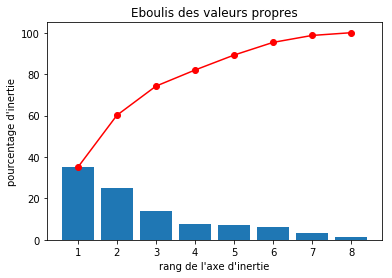

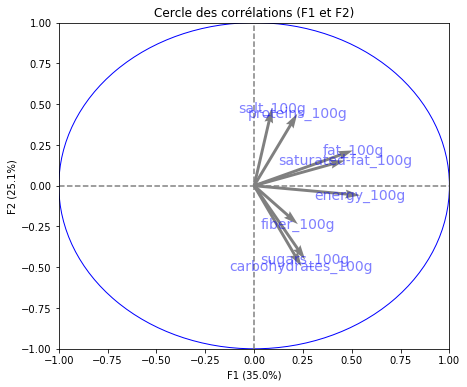

In [23]:
import pandas as pd
import numpy as np
from sklearn import decomposition
from sklearn import preprocessing
from functions import *

# choix du nombre de composantes à calculer
n_comp = 8

# import de l'échantillon
data = train[acp_col]

# selection des colonnes à prendre en compte dans l'ACP
data_pca = train[acp_col]

# préparation des données pour l'ACP
#data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = data.index # ou data.index pour avoir les intitulés
features = data.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)#ici

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Projection des individus
#X_projected = pca.transform(X_scaled)#ici
#display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=np.array(names))
#display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var=pure['is_genuine'])

plt.show()

# KNN

In [24]:
acp_col

['fiber_100g',
 'proteins_100g',
 'energy_100g',
 'saturated-fat_100g',
 'sugars_100g',
 'salt_100g',
 'carbohydrates_100g',
 'fat_100g']

In [25]:
scaler = StandardScaler()
train_sca=(scaler.fit_transform(train[acp_col]))

In [26]:
X_train = train_sca
y_train= train['nutrition-score-fr_100g']

# we could choose differenct neighbors to see which K is the best K.


In [27]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_neighbors': list(range(1,31))}

knn = KNeighborsRegressor()
model = GridSearchCV(knn, parameters, cv=5,scoring='neg_mean_absolute_error')
model.fit(X_train,y_train)
print('Le nb de K optimal pour le MAE :', model.best_params_)
mae=np.abs(model.best_score_)

Le nb de K optimal pour le MAE : {'n_neighbors': 9}


In [28]:
from sklearn.model_selection import GridSearchCV
parameters = {'n_neighbors': list(range(1,31))}

knn = KNeighborsRegressor()
#RMSE
model = GridSearchCV(knn, parameters, cv=5,scoring='neg_root_mean_squared_error')
model.fit(X_train,y_train)
print('Le nb de K optimal pour le RMSE :', model.best_params_)
rmse=(np.abs(model.best_score_))

Le nb de K optimal pour le RMSE : {'n_neighbors': 16}


In [29]:
print ("TRAINING SET( without % nutrition-score-fr_100g)")
print ("=========================================")
print ("MAE:                ", mae)
print ("RMSE:               ", rmse)

TRAINING SET( without % nutrition-score-fr_100g)
MAE:                 2.176053383322187
RMSE:                3.4440734635654096


In [30]:
model.cv_results_

{'mean_fit_time': array([0.26234365, 0.26188855, 0.26183853, 0.26143928, 0.261901  ,
        0.26519985, 0.26169062, 0.26181054, 0.26148195, 0.26222148,
        0.26165714, 0.26125708, 0.26289229, 0.26156316, 0.26157227,
        0.264782  , 0.26431141, 0.26511755, 0.26502161, 0.26555161,
        0.26434288, 0.26510634, 0.26630144, 0.26117153, 0.26126289,
        0.26085429, 0.26073952, 0.26040597, 0.26420231, 0.26043916]),
 'mean_score_time': array([1.04338026, 1.39396133, 1.65194535, 1.85107403, 2.00163364,
        2.15109706, 2.2791121 , 2.39751668, 2.51730695, 2.61599073,
        2.7181797 , 2.81040916, 2.89982276, 2.99875112, 3.08001823,
        3.18847332, 3.27542272, 3.359273  , 3.46836815, 3.50638528,
        3.55487018, 3.63784328, 3.70267291, 3.80435691, 3.84177079,
        3.88479199, 3.95288472, 4.01125207, 4.07598763, 4.13446975]),
 'mean_test_score': array([-4.29449599, -3.81526111, -3.64733513, -3.56951246, -3.52675586,
        -3.49823256, -3.47874022, -3.46946816, -3.45

Text(0, 0.5, 'RMSE')

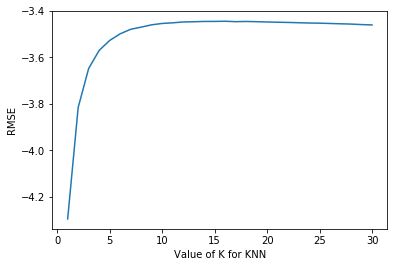

In [31]:
k_range = range(1, 31)
plt.plot(k_range, model.cv_results_['mean_test_score'])
plt.xlabel('Value of K for KNN')
plt.ylabel('RMSE')

# Fonctions préprocessing 

In [32]:
train.columns

Index(['fiber_100g', 'proteins_100g', 'energy_100g', 'saturated-fat_100g',
       'sugars_100g', 'salt_100g', 'carbohydrates_100g', 'fat_100g',
       'mean_tree', 'code', 'product_name', 'nutrition-score-fr_100g',
       'nutriscore_grade', 'verif'],
      dtype='object')

In [33]:
outliers.head()

,Name,Q1,Q3
0,fiber_100g,-5.550,9.250
1,proteins_100g,-13.500,27.300
2,fruits-vegetables-nuts_100g,-81.775,161.625
3,saturated-fat_100g,-11.800,20.200
4,sugars_100g,-21.950,38.450


In [34]:
outliers['Name'].unique()

array(['fiber_100g', 'proteins_100g', 'fruits-vegetables-nuts_100g',
       'saturated-fat_100g', 'sugars_100g', 'salt_100g',
       'carbohydrates_100g', 'fat_100g', 'energy_100g', 'mean_tree'],
      dtype=object)

- La fonction boxplot_methode va dans un premier gérer les valeurs aberrantes en mettant à Nan les valeurs supérieur à 100 et inférieur à 0
- Puis nous récupérons la valeur de l'IRQ dans nos jeux de données outlier pour l'appliquer à notre jeu de données 'test' pour chaque colonne

In [35]:
def boxplot_methode(main_df,df_outliers):
    '''boxplot_methode has to goal to put all the outliers to Nan through the boxplot method, we are going to use the Q1 and Q3 from train dataset'''
    global test,outliers
    boxo=['fiber_100g','proteins_100g','fruits-vegetables-nuts_100g','saturated-fat_100g','sugars_100g','salt_100g','carbohydrates_100g','fat_100g']
    for i in boxo: 
        test.loc[(test[i]<0)|(test[i]>100),
                  i]=test.loc[(test[i]<0)|(test[i]>100),i]=np.nan
        Q1 = int(outliers.loc[outliers['Name']==i,'Q1'])
        Q3 = int(outliers.loc[outliers['Name']==i,'Q3'])
        test.loc[(test[i] < (Q1)) | (test[i] > (Q3)),
                  i]=test.loc[(test[i] < (Q1)) | (test[i] > (Q3)),
                                 i]=np.nan

In [36]:
boxplot_methode(test,outliers)

In [37]:
#Ici nous pouvons constater que le nombre de Nan a augmenté puisque toutes les valeurs aberrantes et outliers st mis à Nan
test.isna().sum()

code                                0
product_name                      584
generic_name                    78544
quantity                        42473
fiber_100g                      61760
proteins_100g                    2996
fruits-vegetables-nuts_100g    100077
energy_100g                       141
saturated-fat_100g               6063
sugars_100g                     11456
salt_100g                        5467
nutrition-score-fr_100g             0
carbohydrates_100g                255
fat_100g                         3822
nutriscore_grade                    0
dtype: int64

In [38]:
def percent_methode(test_df,df_outliers): 
        '''percent_methdode has to goal to put all the outliers to Nan through the boxplot method, we are going to use the Q1 and Q3 from train dataset
        , wich represent the 1st percentile and the 99th percentile'''
        global test,outliers
        colo=['energy_100g']
        for i in colo: 
            Q1 = int(outliers.loc[outliers['Name']==i,'Q1'])
            Q3 = int(outliers.loc[outliers['Name']==i,'Q3'])
            test.loc[(test[i] <= (Q1)) | (test[i] >= (Q3)),
                  i]=test.loc[(test[i] <= (Q1)) | (test[i] >= (Q3)),
                                 i]=np.nan

In [39]:
percent_methode(test,outliers)

In [40]:
test.isna().sum()

code                                0
product_name                      584
generic_name                    78544
quantity                        42473
fiber_100g                      61760
proteins_100g                    2996
fruits-vegetables-nuts_100g    100077
energy_100g                      2220
saturated-fat_100g               6063
sugars_100g                     11456
salt_100g                        5467
nutrition-score-fr_100g             0
carbohydrates_100g                255
fat_100g                         3822
nutriscore_grade                    0
dtype: int64

In [41]:
%%time
def knn_imputation(dataframe):
    '''knn_imputation is going to impute the missing values through KnnImputer that will be stocked into df_filled'''
    global df_filled
    knn=['fiber_100g','proteins_100g',
                'energy_100g','saturated-fat_100g','sugars_100g','salt_100g','carbohydrates_100g','fat_100g']
    with open('StandardScaler_pickle', 'rb') as file: 
        scaler=pickle.load(file)
    data=(scaler.transform(dataframe[knn]))
    with open('imputer_pickle', 'rb') as file: 
        imputer=pickle.load(file)
    df_filled = imputer.transform(data)
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.63 µs


In [42]:
%%time
knn_imputation(test)

CPU times: user 27min 47s, sys: 13min 58s, total: 41min 45s
Wall time: 19min 58s


In [43]:
X=df_filled.copy()
tree = KDTree(X, leaf_size=2)              
dist, ind = tree.query(X, k=5)
dist_mean=[]
for i in dist:
     dist_mean.append(i.mean())
data=(scaler.inverse_transform(df_filled))


In [44]:
#Creation of the new dataframe : "dataframe"
dataframe=pd.DataFrame(data, columns=['fiber_100g','proteins_100g',
                'energy_100g','saturated-fat_100g','sugars_100g','salt_100g','carbohydrates_100g','fat_100g'])
dataframe['mean_tree']=dist_mean



In [45]:
print("dataframe",dataframe.shape)
print("test",test.shape)

dataframe (101579, 9)
test (101579, 15)


In [46]:
#Since we have kept the same order of information, we can simply put the test values into dataframe.
#To retrieve the code, product_name and nutrition score 
dataframe['code']=test['code'].values
dataframe['product_name']=test['product_name'].values
dataframe['nutrition-score-fr_100g']=test['nutrition-score-fr_100g'].values

In [47]:
#The result True is perfectly normal
dataframe['code'].equals(test['code'])

True

In [48]:
#Now it seems that we took care of some redundants articles with their code but there are others with different names
#Since we are using knn and its an algorithm using the distance we need to drop those products
#For this, since I don't know who is who ? We are going to use those columns as a reference and keep only one of them each time
dataframe.drop_duplicates(subset =['fiber_100g','proteins_100g',
                'energy_100g','saturated-fat_100g','sugars_100g','salt_100g','carbohydrates_100g','fat_100g'], 
                     keep = "first", inplace = True) 

In [49]:
#The result False is perfectly normal, we wanted to check if the drop did his job
dataframe['code'].equals(test['code'])

False

In [50]:
print("dataframe",dataframe.shape)

dataframe (88168, 12)


In [51]:
test_clean=dataframe.copy()

In [52]:
test_clean['verif']=test_clean['proteins_100g']+test_clean['carbohydrates_100g']+test_clean['fat_100g']

In [53]:
test_clean.isna().sum()

fiber_100g                   0
proteins_100g                0
energy_100g                  0
saturated-fat_100g           0
sugars_100g                  0
salt_100g                    0
carbohydrates_100g           0
fat_100g                     0
mean_tree                    0
code                         0
product_name               548
nutrition-score-fr_100g      0
verif                        0
dtype: int64

In [54]:
def verification(main_test): 
    global test_clean
    test_clean=test_clean.loc[(test_clean['verif']>=0)&(test_clean['verif']<=100),:]
    outlier_kd=['mean_tree']
    for i in outlier_kd: 
        test_clean=test_clean.loc[(test_clean[i]>=0)|(test_clean[i]<=100),:]
        Q1 = int(outliers.loc[outliers['Name']==i,'Q1'])
        Q3 = int(outliers.loc[outliers['Name']==i,'Q3'])
        test_clean=test_clean.loc[(test_clean[i] < (Q1)) | (test_clean[i] > (Q3 )),
                                 :]

In [55]:
verification(test_clean)

In [56]:
liste_knn=['fiber_100g','proteins_100g',
                'energy_100g','saturated-fat_100g','sugars_100g','salt_100g','carbohydrates_100g','fat_100g']

In [57]:
y_pred1=model.best_estimator_.predict(test_clean[liste_knn])

In [58]:
y_test1=test_clean['nutrition-score-fr_100g']

In [59]:
mae1 = metrics.mean_absolute_error(y_test1, y_pred1)
mse1 = metrics.mean_squared_error(y_test1,y_pred1)
print ("Test SET( without % nutrition-score-fr_100g)")
print ("=========================================")
print ("MAE:                ", mae1)
print ("RMSE:               ", math.sqrt(mse1))

Test SET( without % nutrition-score-fr_100g)
MAE:                 11.136399632732699
RMSE:                13.349612899396245


In [60]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 2197.51411652565 seconds ---
